# TP4


### Environment Setup

In [93]:
##### Import Libraries #####
import pandas as pd
import os
from tqdm.notebook import tqdm
import numpy as np 
import matplotlib.pyplot as plt  
import statsmodels.api as sm    
import seaborn as sns 

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score,roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [94]:
##### Directories #####
#Taking into account that 'TP4' is outside any folder
## General Folders ##
docs = './docs/'
input = './input/'
output = './output/'

## Input Data Bases ##
EPH_hogar = 'EPH_usu_hogar_T123.xlsx'
EPH_individual = 'EPH_usu_individual_T123.xlsx'

## Intermediary Ouput Databases ##
EPH_AMBA_raw_dir = os.path.join(output, 'EPH_AMBA_raw.xlsx')
EPH_AMBA_clean_dir = os.path.join(output, 'EPH_AMBA_clean.xlsx')

respondieron_dir = os.path.join(output, 'Respondieron.xlsx')
norespondieron_dir = os.path.join(output, 'NoRespondieron.xlsx')

## Output Imagenes ##
corr_map_dir = os.path.join(output, 'mapa_de_correlaciones.png')

## Parte 1 - Análisis de la base de hogares y cálculo de pobreza.
  Ahora que ya se han familiarizado con la Encuesta Permanente de Hogares (EPH), asegúrense de estar calculando niveles de pobreza a nivel individual y a nivel de hogar similares a los que calcula el INDEC para la misma región. Además, asegúrense de estar realizando una limpieza de la base con mayor dedicación y entendimiento de sus variables.

##### 1
  Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2023 (la base de hogares se llama [usu_hogar_T123.xls](./input/EPH_usu_hogar_T123.xlsx). Importen los datos de la encuesta de hogar y, al igual que en el TP2, conserven sólo las observaciones que corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o del Gran Buenos Aires.

In [61]:
#Determinamos el directorio de la base de microdatos de la EPH
EPH_hog_dir = os.path.join(input, EPH_hogar)

#Leemos y copiamos dicha base
dataframe = pd.read_excel(EPH_hog_dir)
df_EPH_hog = dataframe.copy()

#Nos quedamos solo con las Obs de CABA y GBA (Aglomerados: 32, 33)
df_EPH_hog_AMBA = df_EPH_hog[df_EPH_hog['AGLOMERADO'].isin([32, 33])]

#Testeamos si lo importamos correctamente:
df_EPH_hog_AMBA.head(5)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,AGLOMERADO,PONDERA,IV1,...,GDECCFR,PDECCFR,ADECCFR,PONDIH,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
9,TQRMNORVYHMOTSCDEIJAH00802517,2023,1,1,1,1,S,33,1066,1,...,12.0,NaN,12,0,1,0,98,0,0,0
10,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,33,2270,2,...,6.0,NaN,7,4733,1,0,2,0,0,0
11,TQSMNOSQRHLLTTCDEIJAH00719389,2023,1,1,1,1,S,33,2161,1,...,7.0,NaN,8,2672,1,0,98,0,0,0
35,TQRMNORTUHKOQQCDEIJAH00780489,2023,1,1,1,1,S,33,3097,1,...,8.0,NaN,9,4844,1,0,98,0,0,0
98,TQRMNOUTRHKNQMCDEIJAH00802590,2023,1,1,1,1,S,33,2571,1,...,8.0,NaN,9,3482,1,0,97,0,0,0


#### 2
 Unan la tabla de la encuesta individual con la de la encuesta de hogar. Asegúrense
de estar usando las variables CODUSU y NRO HOGAR.


In [62]:
#Determinamos el directorio de la base de microdatos de la EPH
EPH_indiv_dir = os.path.join(input, EPH_individual)

#Leemos y copiamos dicha base
dataframe = pd.read_excel(EPH_indiv_dir)
df_EPH_indiv = dataframe.copy()
df_EPH_indiv_AMBA = df_EPH_indiv[df_EPH_indiv['AGLOMERADO'].isin([32, 33])]

In [63]:
#Unimos Ambas bases de Datos, tal que: 1 Obs = Individuo + datos de su hogar
df_EPH_AMBA = pd.merge(df_EPH_indiv_AMBA, df_EPH_hog_AMBA, on=['CODUSU','NRO_HOGAR'], how='inner', suffixes=('_H', '_I')) #solo se queda con las rows que en ambas bases tienen el mismo CODUSU, 'right' lo haria con hogar y NaN faltantes

#Testeamos si lo importamos correctamente:
with pd.option_context('display.max_columns', None): #nos permite temporalmente sacar la restriccion al limite de cols
  df_EPH_AMBA.head(50)

In [66]:
list(df_EPH_AMBA.columns)

['CODUSU',
 'ANO4_H',
 'TRIMESTRE_H',
 'NRO_HOGAR',
 'COMPONENTE',
 'H15',
 'REGION_H',
 'MAS_500_H',
 'AGLOMERADO_H',
 'PONDERA_H',
 'CH03',
 'CH04',
 'CH05',
 'CH06',
 'CH07',
 'CH08',
 'CH09',
 'CH10',
 'CH11',
 'CH12',
 'CH13',
 'CH14',
 'CH15',
 'CH15_COD',
 'CH16',
 'CH16_COD',
 'NIVEL_ED',
 'ESTADO',
 'CAT_OCUP',
 'CAT_INAC',
 'IMPUTA',
 'PP02C1',
 'PP02C2',
 'PP02C3',
 'PP02C4',
 'PP02C5',
 'PP02C6',
 'PP02C7',
 'PP02C8',
 'PP02E',
 'PP02H',
 'PP02I',
 'PP03C',
 'PP03D',
 'PP3E_TOT',
 'PP3F_TOT',
 'PP03G',
 'PP03H',
 'PP03I',
 'PP03J',
 'INTENSI',
 'PP04A',
 'PP04B_COD',
 'PP04B1',
 'PP04B2',
 'PP04B3_MES',
 'PP04B3_ANO',
 'PP04B3_DIA',
 'PP04C',
 'PP04C99',
 'PP04D_COD',
 'PP04G',
 'PP05B2_MES',
 'PP05B2_ANO',
 'PP05B2_DIA',
 'PP05C_1',
 'PP05C_2',
 'PP05C_3',
 'PP05E',
 'PP05F',
 'PP05H',
 'PP06A',
 'PP06C',
 'PP06D',
 'PP06E',
 'PP06H',
 'PP07A',
 'PP07C',
 'PP07D',
 'PP07E',
 'PP07F1',
 'PP07F2',
 'PP07F3',
 'PP07F4',
 'PP07F5',
 'PP07G1',
 'PP07G2',
 'PP07G3',
 'PP07G4',
 

In [70]:
suffixes = {'_H': {}, '_I': {}}
cols_w_suffix = set()

# Find columns with suffixes
for suffix in list(suffixes.keys()):
    cols_w_suffix.update(col[:-len(suffix)] for col in df_EPH_AMBA.columns if col.endswith(suffix))

# Create lists and dictionaries for operations
columns_to_drop = []
columns_to_rename = {}
columns_different= []

# Check and update column names
for col in cols_w_suffix:
    col_1_name = col + list(suffixes.keys())[0]
    col_2_name = col + list(suffixes.keys())[1]

    if all(df_EPH_AMBA[col_1_name] == df_EPH_AMBA[col_2_name]):
        print('The columns with have the same values')
        columns_to_drop.append(col_2_name)
        columns_to_rename[col_1_name] = col
    else:
        print(f'{col_1_name} and {col_2_name} have different values, so we kept both')
        columns_different.append(col)

# Perform operations outside the loop
df_EPH_AMBA.drop(columns=columns_to_drop, inplace=True)
df_EPH_AMBA.rename(columns=columns_to_rename, inplace=True)

IDECCFR_H and IDECCFR_I have different values, so we kept both
PDECIFR_H and PDECIFR_I have different values, so we kept both
PDECCFR_H and PDECCFR_I have different values, so we kept both
IDECIFR_H and IDECIFR_I have different values, so we kept both


In [72]:
# Verificando manualmente la contruccion de la encuesta determinamos que los valores que son diferentes nos quedaremos con solo uno de los valores por simplicidad, elegimos los de hogar ya que los individuales son construidos arbitrariamente con ponderadores.
df_EPH_AMBA.drop(columns=[col + '_I' for col in columns_different], inplace=True)
df_EPH_AMBA.rename(columns={col + '_H': col for col in columns_different}, inplace=True)
                   
df_EPH_AMBA.to_excel(EPH_AMBA_raw_dir, index=False)

print(f'DataFrame saved to {EPH_AMBA_raw_dir}')

DataFrame saved to ./output/EPH_AMBA_raw.xlsx


#### 3
 Limpien la base de datos tomando criterios que hagan sentido, tanto para el tratamiento de valores faltantes, <span style="color:red">de outliers</span>, como así también decidan qué variables categóricas y strings usarán y transfórmenlas de forma que haga sentido para los ejercicios siguientes. Justifiquen sus decisiones.

In [74]:
#Definomos la funcion para eliminar variables con missings

def col_drop_if(drop_if_missings=False, other_criteria=[], df=df_EPH_AMBA):
  #dropear si cualquier valor de la lista esta en la columna
  if other_criteria:
    columns_to_drop = [col for col in df.columns if df[col].isin(other_criteria).any()]
    df = df.drop(columns=columns_to_drop)
  
  #dropear si hay missinings(valores vacios)
  if drop_if_missings:
    df.dropna(axis=1, inplace=True)

  return df


#Definimos la funcion para eliminar observaciones negativas

def drop_neg_obs(cols=[], df=df_EPH_AMBA):
  #transformamos la columna a valores numericos por las dudas
  df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
  #(Checko si es neg) => Chequeo si algun valor es negativo => If si = True => Iniverto todo con "~" y me quedo solo convalores positivos
  df = df[~(df[cols] < 0).any(axis=1)]
  return df


#
def replace_rename_col(col=None, replace_dic={}, new_name=None, df=df_EPH_AMBA):
  df[col] = df[col].replace(replace_dic)
  if new_name:
    df = df.rename(columns={col: new_name})
  return df


#
def categorical_to_dummy(col=None, dummy_names_dic={}, keep_old_col=False, df=df_EPH_AMBA):
  #le agrega a las keys del diccionario la col+"_" como prefijo --> Nos permite ser mas robusto, por si hay valores que no estan en el diccionario, generandolas con nombre identificable igualmente
  complete_dummy_names_dic = {col+ '_' + key: value for key, value in dummy_names_dic.items()}
  #Genera las dummies a partir de los valores categoricos y renombra las dummies segun el diccionario dado
  new_dummies = pd.get_dummies(df[col], prefix=col, dtype=int).rename(columns=complete_dummy_names_dic)
  
  #si keep_old_col = False => drop col vieja
  if ~keep_old_col:
      df = df.drop(columns=[col])

  #le agrega las nuevas dummies al df
  df = pd.concat([df, new_dummies], axis=1)
  return df

In [77]:
# Guardamos una copia del DataFrame original por precaución
df_EPH_AMBA_clean = df_EPH_AMBA.copy()

# Eliminamos observaciones con valores negativos en columnas específicas
df_EPH_AMBA_clean = drop_neg_obs(
                                  cols=['CH06', 'P21', 'IPCF', 'ITF', 'PP08D1', 'PP08J3',  'PP08D4', 'PP08F1','PP08F2', 'PP08J1', 'PP08J2'],
                                  df=df_EPH_AMBA_clean)


# Eliminamos columnas con valores faltantes
df_EPH_AMBA_clean = col_drop_if(
                                  drop_if_missings=True,
                                  other_criteria=[],
                                  df=df_EPH_AMBA_clean)

# Reemplazamos valores en la columna 'MAS_500_H' y renombramos la columna
df_EPH_AMBA_clean = replace_rename_col(
                                  col='MAS_500',
                                  replace_dic={'S': 1, 'N': 0},
                                  new_name='MAS_500',
                                  df=df_EPH_AMBA_clean)

# Reemplazamos valores en la columna 'IV5' y renombramos la columna
df_EPH_AMBA_clean = replace_rename_col(
                                  col='IV5', replace_dic={'1': 1, '2': 0},
                                  new_name='techo_revestido',
                                  df=df_EPH_AMBA_clean)

# Convertimos columnas categóricas en columnas de variables dummy
categorical_list = [
  {'col': 'IV3',
  'dummy_names_dic': {
      '1': 'pisos_revestido',
      '2': 'pisos_cemento',
      '3': 'pisos_sin_revestir',
      '4': 'pisos_sin_especificar'
      }
  },
  {'col': 'IV9',
  'dummy_names_dic': {
      '1': 'baño_adentro',
      '2': 'baño_afuera',
      '3': 'baño_sin'
      }
  },
]

for i in range(0, len(categorical_list)):
  c = categorical_list[i]
  df_EPH_AMBA_clean = categorical_to_dummy(
                                  col=c['col'],
                                  dummy_names_dic=c['dummy_names_dic'],
                                  df=df_EPH_AMBA_clean)

# Muestra el DataFrame resultante con todas las transformaciones
with pd.option_context('display.max_columns', None, 'display.max_rows', 5):
  display(df_EPH_AMBA_clean)

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,CH04,CH05,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,DECIFR,RDECIFR,GDECIFR,ADECIFR,IPCF,DECCFR,RDECCFR,GDECCFR,ADECCFR,PONDIH,REALIZADA,IV1,IV2,IV4,techo_revestido,IV6,IV7,IV8,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,pisos_revestido,pisos_cemento,pisos_sin_revestir,pisos_sin_especificar,IV9_0,baño_adentro,baño_afuera
0,TQRMNORUYHLMSMCDEIJAH00719364,2023,1,1,1,1,1,1,33,1545,1,2,1957-10-17 00:00:00,65,1,1.0,1,2,0,2,1,3,1,2,3,0,1,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,1545,0,4,4,4.0,4,1690,60000,0,0,0,0,0,0,0,0,0,0,0,60000,135000,4,4,4.0,4,67500.0,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0
1,TQRMNORUYHLMSMCDEIJAH00719364,2023,1,1,2,1,1,1,33,1545,2,1,1952-04-07 00:00:00,70,1,1.0,1,2,0,2,1,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,10000,1,1,1.0,1,3074,0,5,4,4.0,5,2910,65000,0,0,0,0,0,0,0,0,0,0,0,65000,135000,4,4,4.0,4,67500.0,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7616,TQRMNOPTXHKORSCDEIJAH00780269,2023,1,1,1,1,1,1,33,1193,1,2,1977-07-31 00:00:00,45,5,1.0,1,2,0,2,1,1,1,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,49000,3,2,3.0,3,1614,32000,5,5,5.0,5,1592,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12.0,12,0.0,12,12,12.0,12,0,1,1,3,2,2,1,1,1,1,1,1,2,1,3,3,2,0,2,2,2,0,0,0,0,2,2,2,1,2,2,2,2,2,2,1,1,2,2,2,2,2,1,2,2,1,2,2,2,2,3,0,3,1,2,3,0,0,0,1,0,0,0,0,1,0
7617,TQRMNOPTXHKORSCDEIJAH00780269,2023,1,1,2,1,1,1,33,1193,3,1,2005-06-17 00:00:00,17,5,1.0,1,2,0,4,1,1,1,4,3,0,4,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,1193,0,0,0,0.0,0,1193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,12.0,12,0.0,12,12,12.0,12,0,1,1,3,2,2,1,1,1,1,1,1,2,1,3,3,2,0,2,2,2,0,0,0,0,2,2,2,1,2,2,2,2,2,2,1,1,2,2,2,2,2,1,2,2,1,2,2,2,2,3,0,3,1,2,3,0,0,0,1,0,0,0,0,1,0


13.5
Se eliminaron 0 outliers de 6020 observaciones


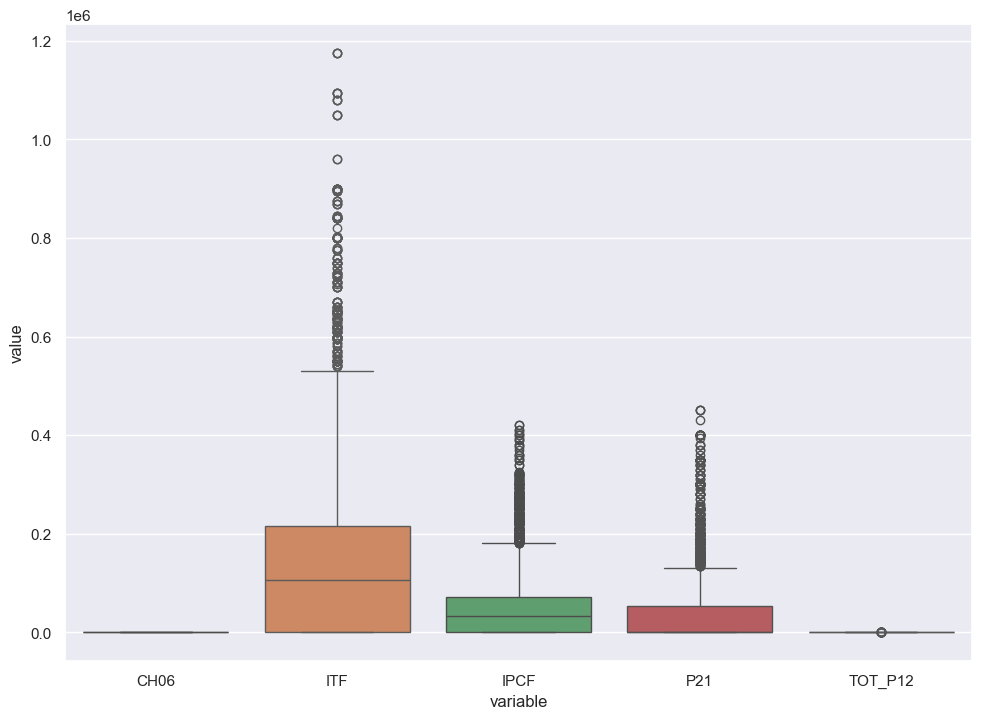

In [91]:
# List of columns with potential outliers
outliers = ['CH06','ITF', 'IPCF', 'P21', 'TOT_P12']

# Set figure size for Seaborn
sns.set(rc={'figure.figsize': (11.7, 8.27)})

#Number of Obs
n_obs = len(df_EPH_AMBA_clean)

# Create a box plot for each variable
for variable in outliers:
    # Create a box plot
    sns.boxplot(x="variable", y="value", data=pd.melt(df_EPH_AMBA_clean[[variable]]))

    # Calculate the upper limit using IQR for the current variable
    Q1 = df_EPH_AMBA_clean[variable].quantile(0)
    Q3 = df_EPH_AMBA_clean[variable].quantile(0.95)
    IQR = Q3 - Q1

    upper_limit = Q3 + 1.5 * IQR

    # Identify and drop rows with outliers for the current variable
    outlier_rows = (df_EPH_AMBA_clean[variable] >= upper_limit)

    df_EPH_AMBA_clean = df_EPH_AMBA_clean[~outlier_rows]

print(upper_limit)
print(f'Se eliminaron {(outlier_rows== True).sum()} outliers de {n_obs} observaciones')

In [79]:
columns_to_drop = ['ANO4', 'TRIMESTRE', 'AGLOMERADO']
df_EPH_AMBA_clean = df_EPH_AMBA_clean.drop(columns_to_drop, axis=1)

#### 4
 Construyan variables (mínimo 2) que no estén en la base pero que sean relevantes para predecir individuos bajo la línea de pobreza (por ejemplo, la proporción de niños en el hogar, si el cónyuge trabaja).

In [80]:
#Crear variable: Conyugue Trabaja

# Crear una columna dummy inicializada en 0
df_EPH_AMBA_clean['CONYUGUE_TRABAJA'] = 0

# Identificar al cónyuge en cada hogar y verificar si trabaja
conyuge_trabaja_mask = (df_EPH_AMBA_clean['CH03'] == '02') & (df_EPH_AMBA_clean['ESTADO'] == '1')

# Asignar el valor 1 a la columna dummy para el cónyuge que trabaja (Tranformamos de True/False a 1/0)
df_EPH_AMBA_clean.loc[conyuge_trabaja_mask, 'CONYUGUE_TRABAJA'] = 1

# Broadcast del valor de la columna dummy a todos los miembros del hogar(Si alguien(conyugue que trabaja) del Hogar tiene valor =1, aplicarselo a todos en el hogar)
df_EPH_AMBA_clean['CONYUGUE_TRABAJA'] = df_EPH_AMBA_clean.groupby(['CODUSU', 'NRO_HOGAR'])['CONYUGUE_TRABAJA'].transform('max')

In [81]:
#Crear Variable: Proporción de niños en el hogar
df_EPH_AMBA_clean['PROP_NIÑOS'] = df_EPH_AMBA_clean['IX_MEN10'] / df_EPH_AMBA_clean['IX_TOT']

In [82]:
#Crear Variable: Hacinamiento

#Calculamos la cantidad de personas por habitación
df_EPH_AMBA_clean['HABITANTES_P_H'] = df_EPH_AMBA_clean['IX_TOT'] / df_EPH_AMBA_clean['II2'] 

#Si #Personas x Habitación es >3, es considerado Hacinamiento
df_EPH_AMBA_clean['HACINAMIENTO'] = np.where(df_EPH_AMBA_clean['HABITANTES_P_H'] >=3, 1, 0)


In [83]:
#Crear Variable: Hogar con acceso al sistema financiero 
#Utilizamos las vars: prestamos a bancos/financieras (V15 = 1), tarjeta de credito (V16 = 1), plazo fijo (V10 = 1). Si alguna de estsas es verdad, significa que tienen accesso al sistema financiero

df_EPH_AMBA_clean['ACCESO_FINANCIERO'] = 1 if any(df_EPH_AMBA_clean[['V10', 'V15', 'V16']].eq(1).any(axis=1)) else 0

In [85]:
# Mostrar el DataFrame resultante
with pd.option_context('display.max_columns', None,'display.max_rows',20):
  display(df_EPH_AMBA_clean)

,CODUSU,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,PONDERA,CH03,CH04,CH05,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,DECIFR,RDECIFR,GDECIFR,ADECIFR,IPCF,DECCFR,RDECCFR,GDECCFR,ADECCFR,PONDIH,REALIZADA,IV1,IV2,IV4,techo_revestido,IV6,IV7,IV8,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,pisos_revestido,pisos_cemento,pisos_sin_revestir,pisos_sin_especificar,IV9_0,baño_adentro,baño_afuera,CONYUGUE_TRABAJA,PROP_NIÑOS,HABITANTES_P_H,HACINAMIENTO,ACCESO_FINANCIERO
0,TQRMNORUYHLMSMCDEIJAH00719364,1,1,1,1,1,1545,1,2,1957-10-17 00:00:00,65,1,1.0,1,2,0,2,1,3,1,2,3,0,1,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,1545,0,4,4,4.0,4,1690,60000,0,0,0,0,0,0,0,0,0,0,0,60000,135000,4,4,4.0,4,67500.00,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0,0,0.000000,2.0,0,1
1,TQRMNORUYHLMSMCDEIJAH00719364,1,2,1,1,1,1545,2,1,1952-04-07 00:00:00,70,1,1.0,1,2,0,2,1,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,10000,1,1,1.0,1,3074,0,5,4,4.0,5,2910,65000,0,0,0,0,0,0,0,0,0,0,0,65000,135000,4,4,4.0,4,67500.00,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0,0,0.000000,2.0,0,1
2,TQRMNOSRQHJNSOCDEIJAH00802640,1,1,1,1,1,8423,1,1,1986-09-26 00:00:00,36,1,4.0,1,2,0,4,1,1,1,4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,40000,2,2,2.0,2,14906,0,2,2,2.0,2,14856,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.5,0,1
3,TQRMNOSRQHJNSOCDEIJAH00802640,1,2,1,1,1,8423,2,2,1994-05-02 00:00:00,28,1,4.0,1,2,0,4,1,1,1,4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,30000,2,2,2.0,2,15878,0,2,2,2.0,2,15231,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.5,0,1
4,TQRMNOSRQHJNSOCDEIJAH00802640,1,3,0,1,1,8423,3,2,2014-03-20 00:00:00,9,5,4.0,1,1,1,2,2,1,1,1,4,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,8423,0,0,0,0.0,0,8423,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7612,TQRMNOPVVHKLRQCDEIJAH00780546,1,1,1,1,1,1236,1,1,1990-04-24 00:00:00,32,1,2.0,1,2,0,6,1,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,200000,9,9,9.0,9,1755,0,9,9,9.0,9,1892,0,0,0,0,0,0,0,0,0,0,0,0,0,480000,10,10,10.0,10,160000.00,9,9,9.0,9,2295,1,1,3,1,1,1,1,1,1,1,2,2,2,3,2,1,1,1,2,2,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,3,1,2,1,2,98,0,0,0,0,0,0,1,0,1,0,0,0.333333,1.5,0,1
7613,TQRMNOPVVHKLRQCDEIJAH00780546,1,2,1,1,1,1236,2,2,1984-04-24 00:00:00,38,1,2.0,1,2,0,6,1,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,250000,10,10,10.0,10,1887,0,10,10,10.0,10,1954,0,0,0,0,0,0,0

#### 5
 Presenten un gráfico (que no sea de barras) para describir la interacción
o correlación entre dos o más variables.


In [ ]:
#Mapa de correlaciones entre variables elegidas
datos_temporal = df_EPH_AMBA_clean.copy()

# Luego, renombra la columna en la copia
datos_temporal.rename

''' COMPLETAR BIEN
# Para restaurar el nombre original, puedes eliminar la columna renombrada de 'datos_temporal'
datos_temporal.rename(columns={'IV5': 'Condición Interior del Techo'}, inplace=True)
datos_temporal.rename(columns={'II7': 'Regimen de Tenencia'}, inplace=True)
datos_temporal.rename(columns={'IV6': 'Conexión de Agua'}, inplace=True)
datos_temporal.rename(columns={'IV12_3': 'Ubicación en Zona de Emergencia'}, inplace=True)
datos_temporal.rename(columns={'IV3': 'Revestimiento del Piso'}, inplace=True)

# Creamos una lista de las variables que queremos incluir en la matriz de correlaciones

variables_a_incluir= ['Condición Interior del Techo', 'Regimen de Tenencia', 'Conexión de Agua','Ubicación en Zona de Emergencia',  'Revestimiento del Piso']
'''

# Crear un DataFrame temporal con las variables seleccionadas
datos_temporal = datos_temporal[variables_a_incluir]

#Creamos la matriz de correlaciones
corr = datos_temporal.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

# Usamos un for anidado para recorrer las filas y columnas de la matriz de correlación y agregar etiquetas a las celdas del mapa de calor.
for i in range(len(variables_a_incluir)):
    for j in range(len(variables_a_incluir)):
        text = f"{corr.iloc[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

# Establecer las etiquetas de las variables en el eje x
ax.set_xticklabels(
    variables_a_incluir,
    rotation=45,
    horizontalalignment='right'
)

#Guardamos el gráfico
plt.savefig(corr_map_dir, dpi=300, bbox_inches='tight')

#Eliminamos los datos temporales
del datos_temporal

#### 6
 Construyan la columna adulto equiv y la columna ad equiv hogar y luego dividan
la base en dos dataframes donde: uno conserve las personas que no reportaron
ITF (dataframe llamado respondieron) y otro conserve a las personas que no
reportaron ITF (llamado norespondieron). Además, agreguen a la base respondieron
una columna llamada ingreso necesario que sea el producto de la canasta
básica por ad equiv hogar. Agreguen a la base respondieron una columna llamada
pobre, que tome valor 1 si el ITF es menor al ingreso necesario que necesita
esa familia y 0 en caso contrario.


In [99]:
# Definir la tabla de equivalencias necesarias eneréticas según edad y sexo
equiv_energ = { 
  1 : { #si es 1 = Varón
    (0, 0.99): 0.35, #0.35 es el valor de un varón menor a 1 año
    (1, 1): 0.37,
    (2, 2): 0.46,
    (3, 3): 0.51,
    (4, 4): 0.55,
    (5, 5): 0.6,
    (6, 6): 0.64,
    (7, 7): 0.66,
    (8, 8): 0.68,
    (9, 9): 0.69,
    (10, 10): 0.79,
    (11, 11): 0.82,
    (12, 12): 0.85,
    (13, 13): 0.9,
    (14, 14): 0.96,
    (15, 15): 1,
    (16, 16): 1.03,
    (17, 17): 1.04,
    (18, 29): 1.02,
    (30, 45): 1,
    (46, 60): 1,
    (61, 75): 0.83,
    (75, 200): 0.74
  },
  2 : { #si es 2 = Mujer
    (0, 0.99): 0.35,
    (1, 1): 0.37,
    (2, 2): 0.46,
    (3, 3): 0.51,
    (4, 4): 0.55,
    (5, 5): 0.6,
    (6, 6): 0.64,
    (7, 7): 0.66,
    (8, 8): 0.68,
    (9, 9): 0.69,
    (10, 10): 0.7,
    (11, 11): 0.72,
    (12, 12): 0.74,
    (13, 13): 0.76,
    (14, 14): 0.76,
    (15, 15): 0.77,
    (16, 16): 0.77,
    (17, 17): 0.77,
    (18, 29): 0.76,
    (30, 45): 0.77,
    (46, 60): 0.76,
    (61, 75): 0.67,
    (75, 200): 0.63
    }
}

#Función para calcular 'adulto_equiv' basado en la edad y el sexo
def calculate_adulto_equiv(row):
  age = row['Edad'] #Obterner valor de "edad" del la row del df
  sex = row['CH04'] #Obterner valor de "edad" del la row del df
  
  if sex in equiv_energ: #Verificar,por las dudas, si el sexo está en el dic
     # Loopear los rangos de edad y valores en el dic
    for (start, end), value in equiv_energ[sex].items():
        if start <= age <= end: 
            return value #Devolver el valor correcto, si la edad está en el rango
  else: 
    print(f'Not found [age:{age}, sex:{sex}]')
  
  return 0 #devolver 0 como valor predeterminado

df_EPH_AMBA_clean.rename(columns={'CH06': 'Edad'}, inplace=True)

df_EPH_AMBA_clean['adulto_equiv'] = df_EPH_AMBA_clean.apply( #guarda el resultado de la funcion
    lambda row: calculate_adulto_equiv(row), axis=1)#Aplica calculate_adulto_equiv a cada fila del df

#Obtener 'ad_equiv_hogar' para cada row del df con groupby y transform
df_EPH_AMBA_clean['ad_equiv_hogar'] = df_EPH_AMBA_clean.groupby('CODUSU')['adulto_equiv'].transform('sum')
#Por el problema: base2 & floating point -> redondeamos a 2 decimales(estandar en esta base de datos)
df_EPH_AMBA_clean['ad_equiv_hogar'] = df_EPH_AMBA_clean['ad_equiv_hogar'].round(2)

In [132]:
# Generamos una dummy llamada respondieron, si indicaron un ingreso mayor a 0 se les asigna un 1
df_EPH_AMBA_clean['respondieron'] = (df_EPH_AMBA_clean['ITF'] > 0).astype(int)

# Sumamos para ver cuanta gente respondio
total_respondieron = df_EPH_AMBA_clean['respondieron'].sum()

print(total_respondieron)

# Repetimos para los que no respondieron (es decir los que reportaron un ingreso = 0)
df_EPH_AMBA_clean['norespondieron'] = (df_EPH_AMBA_clean['ITF'] == 0).astype(int)

total_norespondieron = df_EPH_AMBA_clean['norespondieron'].sum()

print(total_norespondieron)

# Creamos la base 'respondieron'
respondieron = df_EPH_AMBA_clean[df_EPH_AMBA_clean['ITF'] > 0]

# Creamos la base 'norespondieron'
norespondieron = df_EPH_AMBA_clean[df_EPH_AMBA_clean['ITF']==0]

# Creamos una nueva variable llamada ingreso necesario, que contiene la operacion exigida por la consigna
respondieron.loc[:,"ingreso_necesario"] = respondieron["ad_equiv_hogar"] * 57371.05

print(respondieron['ingreso_necesario'])

3903
2117
0        86056.5750
1        86056.5750
2       140559.0725
3       140559.0725
4       140559.0725
           ...     
7611    161786.3610
7612    141132.7830
7613    141132.7830
7614    141132.7830
7615     36143.7615
Name: ingreso_necesario, Length: 3903, dtype: float64


/var/folders/1s/9gsw7p_x39x9cjph153x9wf00000gn/T/ipykernel_2553/338114745.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron.loc[:,"ingreso_necesario"] = respondieron["ad_equiv_hogar"] * 57371.05


In [103]:
#Salvamos la base de Datos procesada por seguridad y facilitar su reuso
df_EPH_AMBA_clean.to_excel(EPH_AMBA_clean_dir, index=False)
print(f'DataFrame saved to {EPH_AMBA_clean_dir}')

# Mostrar el DataFrame resultante
with pd.option_context('display.max_columns', None,'display.max_rows', 100):
  display(df_EPH_AMBA_clean)

DataFrame saved to ./output/EPH_AMBA_clean.xlsx


,CODUSU,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,PONDERA,CH03,CH04,CH05,Edad,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,P21,DECOCUR,RDECOCUR,GDECOCUR,ADECOCUR,PONDIIO,TOT_P12,DECINDR,RDECINDR,GDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,DECIFR,RDECIFR,GDECIFR,ADECIFR,IPCF,DECCFR,RDECCFR,GDECCFR,ADECCFR,PONDIH,REALIZADA,IV1,IV2,IV4,techo_revestido,IV6,IV7,IV8,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,pisos_revestido,pisos_cemento,pisos_sin_revestir,pisos_sin_especificar,IV9_0,baño_adentro,baño_afuera,CONYUGUE_TRABAJA,PROP_NIÑOS,HABITANTES_P_H,HACINAMIENTO,ACCESO_FINANCIERO,adulto_equiv,ad_equiv_hogar,respondieron,norespondieron
0,TQRMNORUYHLMSMCDEIJAH00719364,1,1,1,1,1,1545,1,2,1957-10-17 00:00:00,65,1,1.0,1,2,0,2,1,3,1,2,3,0,1,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0.0,0,1545,0,4,4,4.0,4,1690,60000,0,0,0,0,0,0,0,0,0,0,0,60000,135000,4,4,4.0,4,67500.00,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0,0,0.000000,2.0,0,1,0.67,1.50,1,0
1,TQRMNORUYHLMSMCDEIJAH00719364,1,2,1,1,1,1545,2,1,1952-04-07 00:00:00,70,1,1.0,1,2,0,2,1,1,1,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,10000,1,1,1.0,1,3074,0,5,4,4.0,5,2910,65000,0,0,0,0,0,0,0,0,0,0,0,65000,135000,4,4,4.0,4,67500.00,5,5,5.0,6,2540,1,1,3,4,1,1,2,1,1,1,2,2,2,3,1,2,0,1,1,1,2,0,2,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0,0,0.000000,2.0,0,1,0.83,1.50,1,0
2,TQRMNOSRQHJNSOCDEIJAH00802640,1,1,1,1,1,8423,1,1,1986-09-26 00:00:00,36,1,4.0,1,2,0,4,1,1,1,4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,40000,2,2,2.0,2,14906,0,2,2,2.0,2,14856,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.5,0,1,1.00,2.45,1,0
3,TQRMNOSRQHJNSOCDEIJAH00802640,1,2,1,1,1,8423,2,2,1994-05-02 00:00:00,28,1,4.0,1,2,0,4,1,1,1,4,1,2,0,0,0,0,0,0,0,0,0,0,0,0,30000,2,2,2.0,2,15878,0,2,2,2.0,2,15231,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.5,0,1,0.76,2.45,1,0
4,TQRMNOSRQHJNSOCDEIJAH00802640,1,3,0,1,1,8423,3,2,2014-03-20 00:00:00,9,5,4.0,1,1,1,2,2,1,1,1,4,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,8423,0,0,0,0.0,0,8423,0,0,0,0,0,0,0,0,0,0,0,0,0,70000,2,1,1.0,2,23333.33,1,1,1.0,1,14082,1,1,3,2,1,1,2,1,1,3,2,2,2,3,2,2,0,1,1,1,2,0,2,0,3,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,3,1,2,2,1,98,0,0,0,1,0,0,0,0,1,0,0,0.333333,1.5,0,1,0.69,2.45,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7612,TQRMNOPVVHKLRQCDEIJAH00780546,1,1,1,1,1,1236,1,1,1990-04-24 00:00:00,32,1,2.0,1,2,0,6,1,1,1,6,1,3,0,0,0,0,0,0,0,0,0,0,0,0,200000,9,9,9.0,9,1755,0,9,9,9.0,9,1892,0,0,0,0,0,0,0,0,0,0,0,0,0,480000,10,10,10.0,10,160000.00,9,9,9.0,9,2295,1,1,3,1,1,1,1,1,1,1,2,2,2,3,2,1,1,1,2,2,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,3,1,2,1,2,98,0,0,0,0,0,0,1,0,1,0,0,0.333333,1.5,0,1,1.00,2.46,1,0
7613,TQRMNOPVVHKLRQCDEIJAH00780

#### 7
 Para calcular la tasa de hogares bajo la línea de pobreza utilicen una sola observación por hogar y sumen el ponderador PONDIH que permite expandir la muestra de la EPH al total de la población que representa. ¿Cuál es la tasa de hogares bajo la línea de pobreza para el GBA? ¿Lograron que se asemeje al porcentaje que reporta el INDEC en sus informes?

In [146]:
respondieron['Pobre'] = np.where(respondieron['ITF'] < respondieron['ingreso_necesario'], 1, 0)

hogares_pobreza = respondieron.groupby(['CODUSU','NRO_HOGAR']).agg({"Pobre" : "mean","PONDIH" : "sum"})
#Sumamos cuanto hay de cada uno.
suma_pobres= hogares_pobreza.groupby("Pobre").PONDIH.sum().to_frame()
porcentaje_pobres = suma_pobres.apply(lambda x:
                                                 100 * x / float(x.sum()))
print(porcentaje_pobres)

          PONDIH
Pobre           
0.0    59.937834
1.0    40.062166


/var/folders/1s/9gsw7p_x39x9cjph153x9wf00000gn/T/ipykernel_2553/3830631593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['Pobre'] = np.where(respondieron['ITF'] < respondieron['ingreso_necesario'], 1, 0)


In [ ]:
#Salvamos las base de Datos Respondieron y Norespondieron, procesada por seguridad y facilitar su reuso
respondieron.to_excel(respondieron_dir, index=False)
print(f'DataFrame saved to {respondieron_dir}')

norespondieron.to_excel(norespondieron_dir, index=False)
print(f'DataFrame saved to {norespondieron_dir}')

# Mostrar los DataFrame resultante
with pd.option_context('display.max_columns', None,'display.max_rows',10):
  display(respondieron)
  display(norespondieron)

## Parte 2 Construcción de funciones
El objetivo de esta parte del trabajo es revisar y mejorar el código que escribieron
en la parte II del TP3. Deben buscar que sea flexible y esté modularizado (en funciones
bien documentadas con docstrings). De esta forma, evitarán repetir código y podrán
utilizarlo en distintos escenarios (como por ejemplo la Parte III de este TP y sus proyectos
personales a futuro).

#### 1
 Escriban una función, llamada evalua metodo, que reciba como argumentos un modelo y los datos de entrenamiento y prueba (X train, y train, X test, y test). La función debe ajustar el modelo con los datos de entrenamiento y calcular las métricas que considere necesarias para esta problemática (de mínima, deben reportar verdaderos positivos, verdaderos negativos, falsos positivos, falsos negativos, AUC, accuracy y precision de cada método). El output de la función debe ser una colección con las métricas evaluadas.


#### 2
 Escriban una función, llamada cross validation, que realice validación cruzada con k iteraciones (k-fold CV), llamando a la función del inciso anterior en cada una, pero para las k distintas particiones. La función debe recibir como argumentos el modelo, el valor de k y un dataset (es decir, sólo X e y1). Pueden ayudarse con la función KFold para generar las particiones necesarias. 

#### 3
 Escriban una función, llamada evalua config que reciba una lista de configuraciones de hiperparámetros (los distintos valores a probar como hiperparámetros podrian codificarse en diccionarios de Python) y utilizando la función cross validation obtenga el error2 promedio para cada configuración. Finalmente, la función debe devolver la configuración que genere menor error. Asegúrense de que esta funci ón sirva para cualquier hiperparámetro que quieran elegir por crossvalidation para cualquier modelo. 

#### 4
 Escriban una función llamada evalua multiples metodos que les permita implementar los siguiente métodos que se enumeran a continuación. Esta función debe utilizar su función evalua config para optimizar los parámetros que ustedes decidan (de mínima deben optimizar el K -cantidad de vecinos- para el modelo KNN). Finalmente, el output de la función debe ser una tabla donde las columnas sean las métricas que hayan evaluado (las que hayan incluido en la función evalua metodo) y las filas sean los modelos (con su configuración de hiperpar ámetros asociada) que hayan corrido. Asegúrense de que la tabla incluya una columna con nombre del modelo y el valor de los hiperparámetros/configuración:
 - Regresión logística
 - Análisis de discriminante lineal
 - KNN
 - Arbol de decisión
 - Bagging
 - Random Forests
 - Boosting


## Parte 3 - Clasificación y regularización
El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona es o no pobre utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder cuánto ganan.


#### 1
 Eliminen de ambas bases (respondieron, norespondieron) todas las variables relacionadas
a ingresos (en el archivo Diseño de bases y estructura ver las categorías:
ingresos de la ocupación principal de los asalariados, ingresos de la ocupación principal,
ingresos de otras ocupaciones, ingreso total individual, ingresos no laborales,
ingreso total familiar, ingreso per cápita familiar). Eliminen también las columnas
adulto equiv, ad equiv hogar e ingreso necesario. Establezcan a la variable
pobre como su variable dependiente (vector y). El resto de las variables serán las
variables independientes (matriz X).


#### 2
 Corran la función evalua multiples metodos con la base respondieron. Asegúrense
de estar utilizando su función de evalua config para optimizar algunos
hiperparámetros (de mínima, el K en el modelo KNN).


#### 3
 ¿Cuál de todos los métodos evaluados predice mejor? ¿Con qué hiperparámetros?
Justifiquen mencionando las métricas que conocen.


#### 4
 ¿Lograron mejorar sus predicción respecto al TP34?


#### 5
 Con el método que seleccionaron, predigan qué personas son pobres dentro de la
base norespondieron. ¿Qué proporción de los hogares son pobres en esa submuestra?

In [ ]:
# 